# __Building a simple decision tree model__

The model that will be built will is a classification model to predict molecule solubility

## Requirements for the notebook

First needs to install graphviz as the dtreevix uses it. 
Look Up How To Install it on the specific OS!

!apt-get install graphviz 

Install Packages
!pip install dtreeviz rdkit-pypi PyTDC scikit-learn

**dtreeviz allows for multiple dependencies to be installed**,"https://github.com/parrt/dtreeviz/blob/master/README.md#Installation"

**PyTDC** is a py wrapper of the Therapuetics Data Commons taht contains multiple ML ready datasets


In [19]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors
import math
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dtreeviz.trees import 
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score, RocCurveDisplay, ConfusionMatrixDisplay
from tdc.single_pred import ADME # ADME Dataset
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.rdBase import BlockLogs
import datamol as dm

# Progress bar for pandas
tqdm.pandas()

### **Building definition functions for the tasks that can be automated**

In [5]:
# Calculating the molecular descriptors using a definition.

def calculate_molecular_descriptors(mol="mol"):
    """
    Calculate molecular descriptors for a given molecule.

    Parameters:
    mol (rdkit.Chem.rdchem.Mol): The molecule for which descriptors are calculated.

    Returns:
    list: A list of molecular descriptors [mw, logp, num_arom_rings, hbd, hba].
    """
    if mol:
        # Remove hydrogen atoms
        Chem.DeleteSubstructs(mol, Chem.MolFromSmarts("[#1x0]")) # [#1x0] SMARTS for hydrogen atom
        # Calculate the descriptors
        mw, logp, num_arom_rings, hbd, hba = [x(mol) for x in [MolWt, 
                                                              MolLogP, 
                                                              NumAromaticRings, 
                                                              NumHDonors, 
                                                              NumHAcceptors]]
        # Save descriptors
        descriptors = [mw, logp, num_arom_rings, hbd, hba]
    else:
        # Return None if no molecule is provided for each descriptor
        res = [None] * 5
    return descriptors

# Standerize the molecules as dataset for ADME TDC has salts and other functionalities that 
# cause issues with descirptor calculation

def standardize_mol(smiles="smiles"):
    try:
        """
    Standardizes a molecule by performing various operations such as removing hydrogen atoms,
    disconnected metallic atoms, normalizing molecules, reionizing molecules, neutralizing the molecule,
    and enumerating tautomers.

    Parameters:
    - smiles (str): The SMILES representation of the molecule. Default is "smiles".

    Returns:
    - tautomer_uncharged_parent_clean_mol (rdkit.Chem.rdchem.Mol): The standardized molecule.

    Note:
    - No attempt is made at reionization or ionization at a specific pH.
    - The main aim is to represent all molecules from different sources in a standard way for use in ML, catalog, etc.
    """
        mol = Chem.MolFromSmiles(smiles)

        #remove the hydorgen atoms, diconnected metallic atoms, normalise molecules and reionize molecules 
        clean_mol = rdMolStandardize.Cleanup(mol)

        # If there a lots of fragments then get the "parent" molecule. 
        # This is the actual molecule we want for descriptor calculations
        parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

        # Neitralize the molecule
        uncharger = rdMolStandardize.Uncharger()
        uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)

        # Pat Walter note:
        # note that no attempt is made at reionization at this step
        # nor at ionization at some pH (rdkit has no pKa caculator)
        # the main aim to to represent all molecules from different sources
        # in a (single) standard way, for use in ML, catalogue, etc.

        # Enumerage tautomers of the molecule
        te = rdMolStandardize.TautomerEnumerator()
        tautomer_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)

        return tautomer_uncharged_parent_clean_mol

    except Exception as e:
        print(f"Error with SMILES string: {smiles}")
        print(f"Exception: {e}")
        return None

### __Readin input data from PyTDC ADME__

The data is the from the article ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure "https://pubs.acs.org/doi/10.1021/ci034243x".

The data is supplied by Therapuetic Data Commons

In [6]:
# Download data
data_query = ADME(name= 'Solubility_AqSolDB')
sol_df = data_query.get_data()

Found local copy...
Loading...
Done!


In [7]:
# In the database the columns are: Drug_ID, Drug, and Y which represent 
# Molecule name, Smiles and solubility (log of aqueous solubility in uM).
sol_df.head()

# Rename columns
sol_df.columns = ["Molecule", "SMILES", "LogS"]

# Reorder columns
sol_df = sol_df.reindex(columns=["SMILES", "Molecule", "LogS"])
sol_df.head(2)


,SMILES,Molecule,LogS
0,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],"N,N,N-trimethyloctadecan-1-aminium bromide",-3.616127
1,O=C1Nc2cccc3cccc1c23,Benzo[cd]indol-2(1H)-one,-3.254767


In [8]:
# Standarizing and cleaning the molecules
with dm.without_rdkit_log():
    sol_df["mol"] = sol_df.SMILES.apply(standardize_mol)

Error with SMILES string: CN1C=CC=C/C1=C\[NH+]=O.[I-]
Exception: Invariant Violation
	could not find atom2
	Violation occurred on line 228 in file Code/GraphMol/Canon.cpp
	Failed Expression: firstFromAtom2
	RDKIT: 2023.09.5
	BOOST: 1_78



In [9]:
#Print shape of dataframe
print(f"Shape of dataframe: {sol_df.shape}")

# Find molecules with no data in mol column
no_mol_df = sol_df[sol_df.mol.isnull()]

# Drop no_mol_df from sol_df
sol_df =sol_df.drop(no_mol_df.index).copy()

print(f"Shape of dataframe: {sol_df.shape}")

Shape of dataframe: (9982, 4)
Shape of dataframe: (9981, 4)


Text(9.497079629629633, 0.5, 'Count')

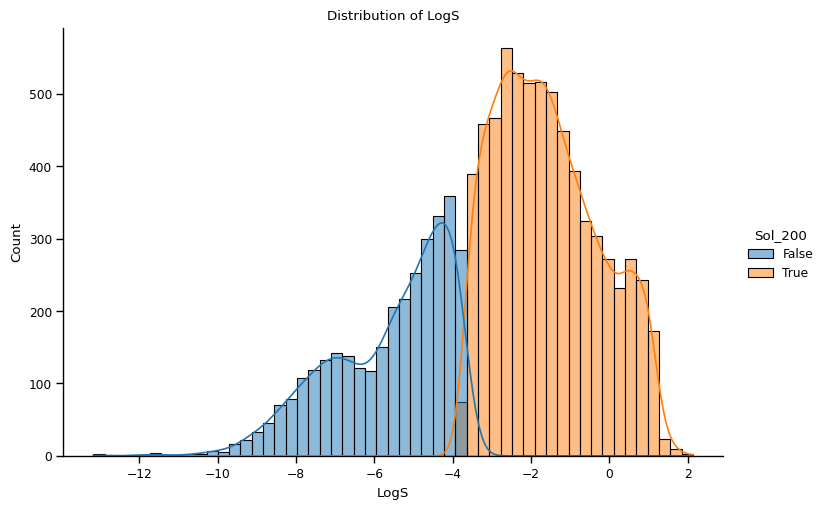

In [10]:
# Adding a new column to determine which molecules solbility is > 200uM
sol_df["Sol_200"] = sol_df.LogS > math.log10(200 * 1e-6) # Make a True and fasle plot

# Make a plot of the distribution of solubility
#Set fonts
sns.set_context("paper")
sns.displot(data=sol_df, x="LogS", kde=True, aspect=1.5, hue="Sol_200")
plt.title("Distribution of LogS")
plt.xlabel("LogS")
plt.ylabel("Count")


In [11]:
# Determine descriptors
sol_df["descriptors"] = sol_df.mol.apply(calculate_molecular_descriptors)

# Descriptrs are saved into singlar column. Therefore need to split
desc_cols = ['MW','LogP','NumAromatic','HBD','HBA']
sol_df[desc_cols] = sol_df.descriptors.to_list()

# Drop descriptors column
sol_df.drop("descriptors", axis=1, inplace=True)

# Look at dataframe
sol_df

,SMILES,Molecule,LogS,mol,Sol_200,MW,LogP,NumAromatic,HBD,HBA
0,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],"N,N,N-trimethyloctadecan-1-aminium bromide",-3.616127,<rdkit.Chem.rdchem.Mol object at 0x16a77aab0>,True,312.606,6.95410,0.0,0.0,0.0
1,O=C1Nc2cccc3cccc1c23,Benzo[cd]indol-2(1H)-one,-3.254767,<rdkit.Chem.rdchem.Mol object at 0x16a77ab20>,True,169.183,2.40550,2.0,1.0,1.0
2,O=Cc1ccc(Cl)cc1,4-chlorobenzaldehyde,-2.177078,<rdkit.Chem.rdchem.Mol object at 0x16a77ab90>,True,140.569,2.15250,1.0,0.0,1.0
3,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",-3.924409,<rdkit.Chem.rdchem.Mol object at 0x16a77aa40>,False,346.426,5.39400,3.0,2.0,2.0
4,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,-4.662065,<rdkit.Chem.rdchem.Mol object at 0x16a77ac00>,False,422.525,2.48540,2.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...
9977,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,tetracaine,-3.010000,<rdkit.Chem.rdchem.Mol object at 0x16b4cdc40>,True,264.369,2.61700,1.0,1.0,4.0
9978,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,tetracycline,-2.930000,<rdkit.Chem.rdchem.Mol object at 0x16b4cdcb0>,True,444.440,-1.46800,1.0,4.0,9.0
9979,Cc1ccc(C(C)C)c(O)c1,thymol,-2.190000,<rdkit.Chem.rdchem.Mol object at 0x16b4cdd20>,True,150.221,2.82402,1.0,1.0,1.0
9980,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,verapamil,-3.980000,<rdkit.Chem.rdchem.Mol object at 0x16b4cdd90>,False,454.611,5.09308,2.0,0.0,6.0


### __Building of the ML Model__

1. Split dataset

2. Train Classifier

3. Predict test set

4. Analysis of model accuarcy and precision

In [12]:
# Splitting data
train, test = train_test_split(sol_df, test_size=0.2, random_state=42)

X_train = train[desc_cols]
X_test = test[desc_cols]
y_train = train.Sol_200
y_test = test.Sol_200

In [13]:
# Train the model
classifier = DecisionTreeClassifier(random_state=42, max_depth=2, criterion="gini")
classifier.fit(X_train, y_train)

#predictions
y_pred = classifier.predict(X_test)

In [14]:
# Analysis of the results
auc, mcc, kappa = roc_auc_score(y_test, y_pred), matthews_corrcoef(y_test, y_pred), cohen_kappa_score(y_test, y_pred)

print(f"AUC: {auc:.2f}")
print(f"Mathews Correlation Coefficient: {mcc:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")

AUC: 0.82
Mathews Correlation Coefficient: 0.64
Cohen's Kappa: 0.64


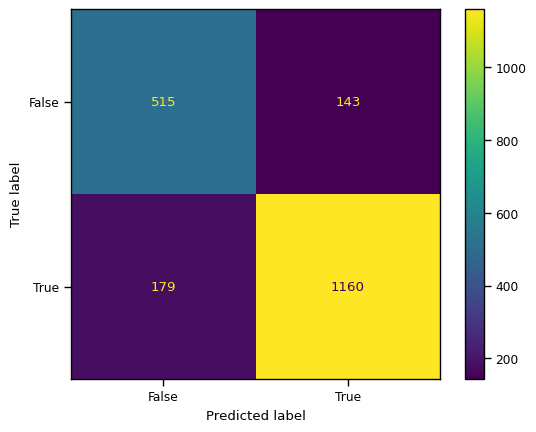

In [15]:
# Visualize the confusion matrix to show the performance of the model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

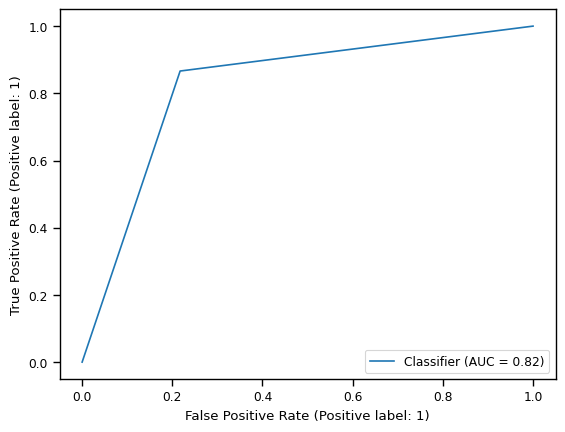

In [16]:
# ROC curve to dispaly the performance of the model
RocCurveDisplay.from_predictions(y_test, y_pred)

[Text(0.5, 0.8333333333333334, 'LogP <= 2.946\ngini = 0.44\nsamples = 7984\nvalue = [2611, 5373]'),
 Text(0.25, 0.5, 'LogP <= 2.683\ngini = 0.206\nsamples = 5275\nvalue = [616, 4659]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.173\nsamples = 4908\nvalue = [470, 4438]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.479\nsamples = 367\nvalue = [146, 221]'),
 Text(0.75, 0.5, 'LogP <= 3.87\ngini = 0.388\nsamples = 2709\nvalue = [1995, 714]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.489\nsamples = 1031\nvalue = [593, 438]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.275\nsamples = 1678\nvalue = [1402, 276]')]

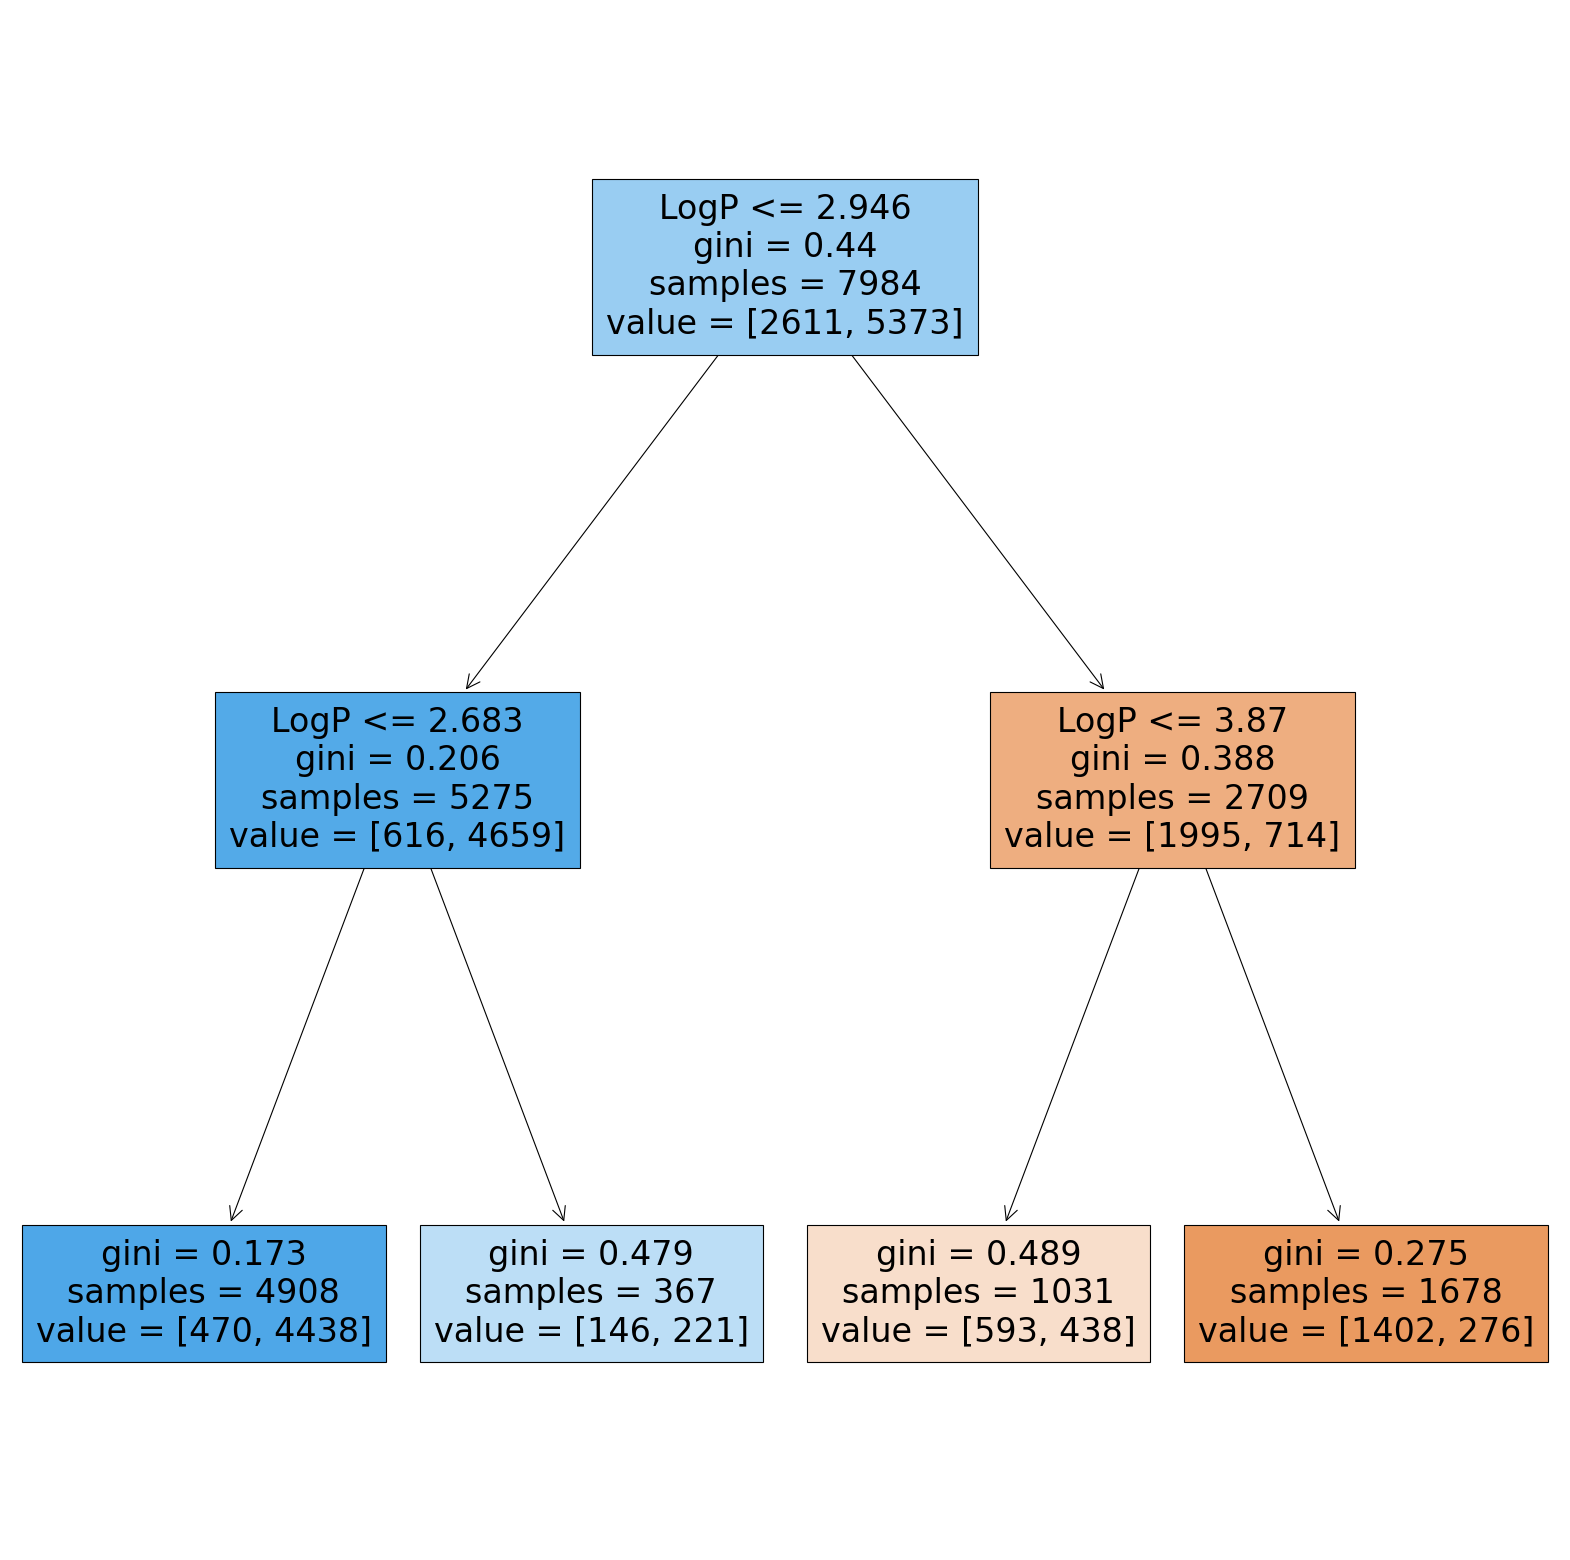

In [17]:
# Plotting the decision tree
plt.rcParams["figure.figsize"] = (20, 20)
plot_tree(classifier, filled=True, feature_names=desc_cols)

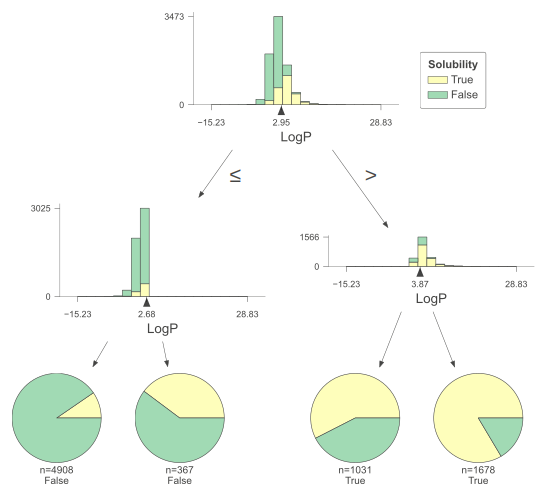

In [32]:
# Using dtreeviz to plot the decision tree
viz = dtreeviz.model(classifier, 
                    X_train=X_train, 
                    y_train=y_train, 
                    target_name='Solubility', 
                    feature_names=desc_cols,
                    class_names=["True", "False"],
                    )

viz.view(scale=1.5)

### __Pat walters notes__

```python
As a final check we're going to see if we can fit a model to incorrect data. If we shuffle the y values, we shouldn't be able to get a good model.

Shuffle the y-variable as a sanity check
```

In [31]:
# Shuffling the y data
sol_df["fake_Sol_200"] = sol_df.Sol_200.sample(frac=1)

# Splitting data
fake_train, fake_test = train_test_split(sol_df, test_size=0.2, random_state=42)

fake_X_train = fake_train[desc_cols]
fake_y_train = fake_train.fake_Sol_200
fake_X_test = fake_test[desc_cols]
fake_y_test = fake_test.fake_Sol_200

# Train the model
fake_classifier = DecisionTreeClassifier(random_state=42, max_depth=2, criterion="gini")
fake_classifier.fit(fake_X_train, fake_y_train)

# Predictions
fake_y_pred = fake_classifier.predict(fake_X_test)

# Analysis of the results
auc, mcc, kappa = roc_auc_score(y_test, y_pred), matthews_corrcoef(y_test, y_pred), cohen_kappa_score(y_test, y_pred)

print(f"AUC: {auc:.2f}")
print(f"Mathews Correlation Coefficient: {mcc:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")

AUC: 0.82
Mathews Correlation Coefficient: 0.64
Cohen's Kappa: 0.64
